In [ ]:
import os
import random
import time
from PIL import Image

import cv2
import numpy as np
import timm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import torchsummaryX


In [85]:
# -- coding: utf8 --
'''ResNet을 이용한 개 고양이 분류기 '''
''' ####################### 1. 라이브러리 ####################### '''
# load to CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available() == True:
    print("\n### cuda check ###")
    print(device)                                                         
    print('Count of using GPUs:', torch.cuda.device_count())    
    print('Current cuda device:', torch.cuda.current_device())                          

# from PIL import Image                               # 기본 이미지 처리 라이브러리. 다양한 이미지 파일 형식 접근, 이미지 조작 제공
from torch.utils.data import DataLoader, Dataset    # 훈련모델 데이터셋 관리와 조정에 쓰이는 라이브러리
# Dataset: 샘플과 정답(label)을 저장, DataLoader: Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다




### cuda check ###
cuda
Count of using GPUs: 1
Current cuda device: 0



In [86]:

''' ####################### 2. 이미지 전처리 ####################### '''


def normalize_image(img):
    img = transforms.ToTensor()(img)
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = (img - mean) / std
    return img



def custom_transform(resize, mean, std, is_train):     # 내가 만든 함수(transform.Compose 안 쓴다)
    transform_list = []
    
    if is_train:    # 훈련용
        transform_list.append(transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)))
        transform_list.append(transforms.RandomHorizontalFlip())
    else:           # 검증용
        transform_list.append(transforms.Resize(256))
        transform_list.append(transforms.CenterCrop(resize))
        
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean, std))
    
    def apply_transform(x):
        for transform in transform_list:
            x = transform(x)
        return x
    
    return apply_transform


class ImageTransform():                     # 책에 있는 transforms.Compose 쓰는 함수
    def __init__(self, resize, mean, std):
        # transform에서 사용하는 파라미터는 다음 5개가 있다.
        self.data_transform = {     # 딕셔너리로 구분할 수 있게 만들었다. 
            'train': custom_transform(resize, mean, std, is_train= True),   # 훈련용
            'val': custom_transform(resize, mean, std, is_train = False)    # 검증용
            }
        
    def __call__(self, img, phase):                 
        # __call__: 클래스를 호출할 수 있도록 하는 메서드. 
        # __init__이 인스턴트 초기화에 쓰이는 생성자라면 __call__은 호출하면 구냥 __call__의 return값을 반환한다.
        return self.data_transform[phase](img)



    # 이미지 사이즈가 다 다르다. 같은 이미지 사이즈로 전처리가 필요함.


# 변수에 대한 값 정의
size = 224                      # 224 x 224 이미지로 만들꺼니깐

# imagenet 쓸때 국롤
mean = (0.485, 0.456, 0.406)    # 왜 이렇게 하는지 물어보기. RGB값인지? 
std = (0.229, 0.224, 0.225)


batch_size = 32                 
# 한 번에 32개씩 불러온다


In [87]:

''' ####################### 3. 이미지 불러오기 ####################### '''

# 데이터로더 (데이터셋 불러오기)
cat_directory = 'dataset/training_set/cats'
dog_directory = 'dataset/training_set/dogs'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] 
# imread가 성공하면 correct_images_filepaths에 이미지를 불러온다.



# 랜덤 시드 고정하고 훈련, 검증, 테스트셋 나누기
# 개 4000개, 고양이 4000개 섞기 (총 8000개)
random.seed(42)    
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:7000]     # 6999번째까지 훈련용
val_images_filepaths = correct_images_filepaths[7000:-10]    # 7000번째 ~ 끝에서 10개까지 검증용(매 에포크마다 검증용) 
test_images_filepaths = correct_images_filepaths[-10:]      # 끝에 10개는 테스트용(최종 확인용)
print("\n### dataset load ###")
print('train: ', len(train_images_filepaths), 'val: ', len(val_images_filepaths), 'test: ',len(test_images_filepaths))   # 잘 분류됐나 확인 코드



# 이미지에 대한 데이터셋 클래스(레이블 구분) 만들기(이미지파일 이름으로 레이블 생성하고 나누기) 
class DogvsCatDataset(Dataset):              # Dataset 클래스를 상속한다.  
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        

        label = img_path.split('/')[-1].split('.')[0]     
        # 이미지 데이터에 대한 레이블값을 가져온다(이미지파일 이름을 .로 구분하고 첫째껄 가져온다)
        # 이미지의 path에서 /로 먼저 나누고 .으로 나중에 나눈다. 
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label


# 이미지 데이터셋 정의(위에서 만든 ImageTransform, DogvsCatDataset 클래스 이용)
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

# 첫번째 이미지 테스트(index = 0)
index_test = 13
print("index_test's input shape: ", train_dataset.__getitem__(index_test)[0].size())     # 출력: torch.Size([3, 224, 224]) 
print("index_test's label: ", train_dataset.__getitem__(index_test)[1])                  # 출력: 0(cat) or 1(dog) 
# __getitem__: 파이썬의 특별 메소드 중 하나이다. 
# 슬라이싱을 구현할 수 있도록 도우며 리스트에서 슬라이싱을 하게되면 내부적으로 __getitem__ 메소드를 실행한다.
# 객체에서 슬라이싱을 하기 위해선 __getitem__이 필수적이다. 


# 배치 크기만큼 나눠서 데이터를 메모리로 불러오기
train_iterator  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print("batch_iterator's size", inputs.size())       # 출력: torch.Size([배치사이즈, 3, 224, 224]) 
print("batch_iterator's label", label)              # 출력: 배치 사이즈 만큼의 라벨링된 숫자





### dataset load ###
train:  7000 val:  995 test:  10
index_test's input shape:  torch.Size([3, 224, 224])
index_test's label:  0
batch_iterator's size torch.Size([32, 3, 224, 224])
batch_iterator's label tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


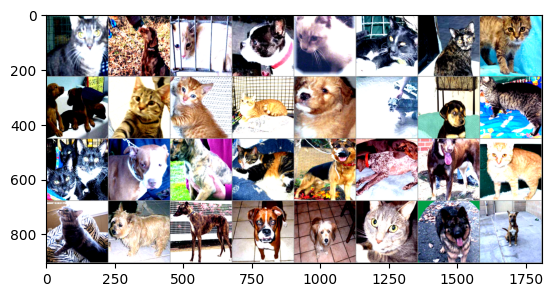

In [88]:

# 배치로 불러온 이미지들 띄우기
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.6     # unnormalize -> 이거 왜 하는건지 물어보기
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(inputs))


In [102]:
''' ####################### 4. 모델 정의 ####################### '''


''' 미리 만들어진 ResNet 불러오기 '''
# timm으로 모델 불러오기
# import timm
# model = timm.create_model("resnet50", pretrained= False)
# # model.fc = nn.Sequential(
# #     nn.
# # )


# torchsummaryX.summary(model, torch.zeros(1,3,224,224))

# model = model.to(device)

# model

# 모델 생성하기
class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:      # 다운샘플 적용: 입력 데이터의 크기와 네트워크를 통과한 후 출력 데이터의 크기가 다를 경우에 사용
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i  # 아이덴티티 매핑 적용 
        x = self.relu(x)
        
        return x



class Bottleneck(nn.Module):    
    expansion = 4   # 병목 블록을 정의하기 위한 파라미터
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x


class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):   
        layers = []        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)        
        return x, h

from collections import namedtuple      # namedtuple: 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있다.
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])


OUTPUT_DIM = 2  # 2개의 클래스 사용
model = ResNet(resnet18_config, OUTPUT_DIM)
print(model)


In [ ]:

''' 옵티마이저, 손실함수 정의 '''
# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr = 1e-4)    # 1*10의 -4제곱
# 국롤은 -3~-4

# 손실함수 정의 
criterion = nn.CrossEntropyLoss()   #  다중 클래스 분류를 위해 사용한다. BCELoss로도 써보기 


''' 모델 디바이스에 전송하기 '''
model = model.to(device)
criterion = criterion.to(device)

''' 모델 요약 '''
# from IPython.core.interactiveshell import InteractiveShell      # 주피터에서 라인을 모두 보고 싶을때 사용한다.
# InteractiveShell.ast_node_interactivity = "all"

# print(model)    # 모델 구성 모두 보고 싶을때

# from torchsummary import summary    # 모델 요약만 보고 싶을때
# summary(model, input_size=(3, 224, 224))


def count_parameters(model):           
    return sum(p.numel() for p in model.parameters() if p.requires_grad)    # 모델의 총 파라미터 수 계산

print(f'The model has {count_parameters(model):,} trainable parameters')

In [94]:
''' ####################### 5. 모델 학습 ####################### '''

# 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k


# 학습함수 정의
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()                
        y_pred = model(x)  
        
        loss = criterion(y_pred[0], y) 
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)        
        loss.backward()        
        optimizer.step()        
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5


# 평가함수 정의
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)            
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




In [95]:

# 학습 시작
best_valid_loss = float('inf')
EPOCHS = 50

train_loss_plt = []
valid_loss_plt = []
train_acc_plt = []
valid_acc_plt = []

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    train_loss_plt.append(train_loss)
    valid_loss_plt.append(valid_loss)
    train_acc_plt.append(train_acc_1)
    valid_acc_plt.append(valid_acc_1)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ResNet-model.pth')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


# 손실과 정확도 그래프 출력


plt.figure(figsize=(13, 5))
fig, axs = plt.subplots(1, 2)
fig.tight_layout()


ax1 = plt.subplot(1,2,1)
plt.title('Loss Graph')
ax1.plot(train_loss_plt, c="blue", label='Trainset_loss')
ax1.plot(valid_loss_plt, c="cornflowerblue", label='Testset_loss')
ax1.legend(['train_loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')


ax2 = plt.subplot(1,2,2)
plt.title('Accuracy Graph')
ax2.plot(train_acc_plt, c="red", label='Trainset_acc')
ax2.plot(valid_acc_plt, c="lightcoral", label='Testset_acc')
ax2.legend(['train_acc', 'val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)


plt.savefig('savefig_default.png')
plt.show()




IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)